In [25]:
import requests
import folium
import geopandas as gpd
from shapely.geometry import shape
from pyproj import CRS
import json
import os

1. MEMANGGIL DATA SPASIAL DARI MAPID API DAN MENAMPILKANNYA MENGGUNAKAN FOLIUM

In [26]:
import requests, folium, geopandas as gpd
url = "https://geoserver.mapid.io/layers_new/get_layer?api_key=d96fcd98a91f4954ba5a51a8de2c3554&layer_id=6890de6d623dcfb726e90c33&project_id=67d241e182926d98678eea8b"
data_spasial = requests.get(url)
if data_spasial.status_code == 200:
    data=data_spasial.json()
    print("API Berhasil diambil")
else:
    print("Gagal, status:",data_spasial.status_code)
m = folium.Map(location=[-6.95, 107.68], zoom_start=12)
gj = folium.GeoJson(data, name="geojson").add_to(m)
m.fit_bounds(gj.get_bounds())
m

API Berhasil diambil


2. KONVERSI KE GEODATAFRAME DAN CEK CRS

a. Cek Tipe Data dan Cek CRS 

In [27]:
#Pengecekan Tipe Data
features = data.get("features", [])
jumlah_baris = len(features)
jumlah_kolom = len(features[0].get("properties", {})) if features else 0
print("Jumlah baris (features):", jumlah_baris)
print("Jumlah kolom (properties):", jumlah_kolom)

if features:
    sample_props = features[0].get("properties", {})
    print("=== Struktur Kolom & Tipe Data ===")
    for key, value in sample_props.items():
        print(f"{key} → {type(value).__name__}")
else:
    print(" Tidak ada fitur dalam data")

#Pengecekan CRS
if features:
    coords = features[0].get("geometry", {}).get("coordinates", [])

    if coords:
        # MultiPolygon: ambil titik pertama
        if isinstance(coords[0], list):
            if isinstance(coords[0][0], list):
                sampel = coords[0][0][0][:2]
            else:
                sampel = coords[0][:2]
        else:
            sampel = coords[:2]

        lon, lat = sampel

        if -180 <= lon <= 180 and -90 <= lat <= 90:
            crs = CRS.from_epsg(4326)
            print("CRS: EPSG:4326 (WGS84 / derajat)")
        else:
            crs = CRS.from_epsg(3857)
            print("CRS: EPSG:3857 (Projected / meter)")
    else:
        print("Koordinat tidak terbaca")
else:
    print("Tidak ada fitur data pada API")


Jumlah baris (features): 100
Jumlah kolom (properties): 6
=== Struktur Kolom & Tipe Data ===
fid → int
KABKOT → str
KECAMATAN → str
DESA → str
JUMLAH PENDUDUK → int
KELAS → str
CRS: EPSG:4326 (WGS84 / derajat)


b. Konversi ke Geo Data Frame 

In [28]:
gdf=gpd.GeoDataFrame.from_features(data.get("features", []))
print(gdf.head())

                                            geometry    fid        KABKOT  \
0  MULTIPOLYGON Z (((107.66286 -6.9463 0, 107.662...  69356  KOTA BANDUNG   
1  MULTIPOLYGON Z (((107.68846 -6.95045 0, 107.68...  69354  KOTA BANDUNG   
2  MULTIPOLYGON Z (((107.62167 -6.94278 0, 107.62...  69353  KOTA BANDUNG   
3  MULTIPOLYGON Z (((107.56871 -6.94956 0, 107.56...  69350  KOTA BANDUNG   
4  MULTIPOLYGON Z (((107.64517 -6.9475 0, 107.645...  69349  KOTA BANDUNG   

         KECAMATAN         DESA  JUMLAH PENDUDUK   KELAS  
0         BUAHBATU     SEKEJATI            26161  TINGGI  
1         GEDEBAGE  RANCABOLANG            12528  SEDANG  
2            REGOL    PASIRLUYU            17541  TINGGI  
3  BABAKAN CIPARAY    MARGASUKA            12755  SEDANG  
4         BUAHBATU    MARGASARI            42861  TINGGI  


3. BUFFER POLYGON

a. Reproject data ke CRS meter (EPSG:3857)

In [29]:
#Set gdf.crs ke EPSG:4326 
if gdf.crs is None:
    gdf = gdf.set_crs(epsg=4326)
    print("CRS di-set ke EPSG:4326")

# Reproject ke EPSG:3857
gdf_proj = gdf.to_crs(epsg=3857)
print("CRS setelah reproject menjadi:", gdf_proj.crs)


CRS di-set ke EPSG:4326
CRS setelah reproject menjadi: EPSG:3857


b. Buffer 100 m

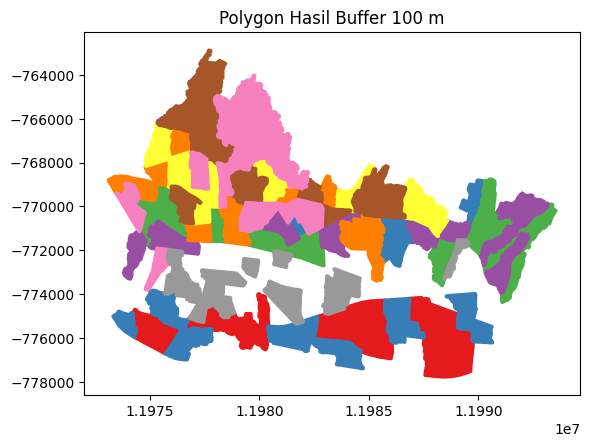

In [30]:
buffered_geom = gdf_proj.geometry.buffer(100)

#visualisasi
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gpd.GeoSeries(buffered_geom).plot(ax=ax, cmap='Set1')
plt.title("Polygon Hasil Buffer 100 m")
plt.show()

c. Mengembalikan ke EPSG 4326 dan Export ke GeoJSON

In [31]:
gdf_buffer = gpd.GeoDataFrame({'geometry': buffered_geom},crs=gdf_proj.crs)

#Mengembalikan ke EPSG 4326
gdf_buffer = gdf_buffer.to_crs(epsg=4326)
print("CRS setelah reproject kembali menjadi:", gdf_buffer.crs)

#export ke GeoJSON
buffered_path = r"D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Buffer_100m.geojson"
gdf_buffer.to_file(buffered_path, driver="GeoJSON")

print("File buffer polygon tersimpan di", buffered_path)


CRS setelah reproject kembali menjadi: EPSG:4326
File buffer polygon tersimpan di D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Buffer_100m.geojson


4. SIMPLIFY POLYGON

a. Reproject data ke CRS meter (EPSG:3857)

In [36]:
# Reproject ke EPSG:3857
gdf_proj = gdf_proj.to_crs(epsg=3857)
print("CRS setelah reproject kembali menjadi:", gdf_proj.crs)

CRS setelah reproject kembali menjadi: EPSG:3857


b. Simplify dengan toleransi 50 m

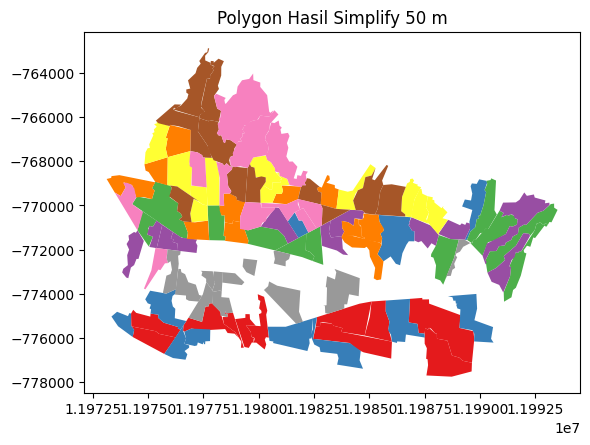

In [37]:
simplified_geom = gdf_proj.simplify(50)

#visualisasi
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gpd.GeoSeries(simplified_geom).plot(ax=ax, cmap='Set1')
plt.title("Polygon Hasil Simplify 50 m")
plt.show()

c. Mengembalikan ke EPSG 4326 dan Export ke GeoJSON

In [40]:
gdf_simply = gpd.GeoDataFrame({'geometry': simplified_geom},crs=gdf_proj.crs)

#Mengembalikan ke EPSG 4326
gdf_simply = gdf_simply.to_crs(epsg=4326)
print("CRS setelah reproject kembali menjadi:", gdf_simply.crs)

#export ke GeoJSON
simplified_path = r"D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Simplified_50m.geojson"
gdf_simply.to_file(simplified_path, driver="GeoJSON")

print(" File tersimpan:", simplified_path)

CRS setelah reproject kembali menjadi: EPSG:4326
 File tersimpan: D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Simplified_50m.geojson


5. CLIP POLYGON DENGAN BOUNDING BOX

a. Membuat Bounding Box

CRS setelah reproject kembali menjadi: EPSG:4326


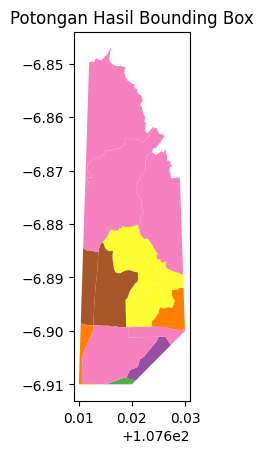

In [51]:
#Mengembalikan ke EPSG 4326
gdf_proj = gdf_proj.to_crs(epsg=4326)
print("CRS setelah reproject kembali menjadi:", gdf_proj.crs)

from shapely.geometry import Polygon
poly=gdf_proj
bbox = Polygon([
    [107.62, -6.60], [107.63, -6.90], [107.62, -6.91], [107.61, -6.91]
])
clipped_bbox = poly.intersection(bbox)

#visualisasi
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gpd.GeoSeries(clipped_bbox).plot(ax=ax, cmap='Set1')
plt.title("Potongan Hasil Bounding Box")
plt.show()

b. Export GeoJSON

In [ ]:
gdf_bbox = gpd.GeoDataFrame({'geometry': clipped_bbox},crs=gdf_proj.crs)
bbox_path = r"D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_BoundingBox.geojson"
gdf_bbox.to_file(bbox_path, driver="GeoJSON")

print(" File tersimpan:", bbox_path)

 File tersimpan: D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_BoundingBox.geojson


6. DISSOLVE POLYGON

a. Dissolve per kelas

In [55]:
gdf_dissolve = gdf_proj.dissolve(by='KELAS')
print("Dissolve berhasil dilakukan")

Dissolve berhasil dilakukan


b. Export ke GeoJSON

In [103]:
dissolve_path = r"D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Dissolve.geojson"
gdf_dissolve.to_file(dissolve_path, driver="GeoJSON")

print(" File tersimpan:", dissolve_path)

 File tersimpan: D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Dissolve.geojson


7. UNION POLYGON

a. Union semua polygon

In [72]:
gdf_union=gdf_proj.unary_union
print("Union berhasil dilakukan")

Union berhasil dilakukan


C:\Users\HP 01\AppData\Local\Temp\ipykernel_12852\1544842457.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_union=gdf_proj.unary_union


b. Export Ke GeoJSON

In [100]:
gdf_uniozed = gpd.GeoDataFrame({'geometry': [gdf_union]},crs=gdf_proj.crs)
union_path = r"D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Union.geojson"
gdf_uniozed.to_file(union_path, driver="GeoJSON")

print(" File tersimpan:", union_path)

 File tersimpan: D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Union.geojson


8. TAMBAH KOLOM AREA DAN HITUNG LUASAN

a. Melakukan perhitungan area dalam kilometer persegi

In [104]:
#Konversi ke EPSG 3857
gdf_proj = gdf_proj.to_crs(epsg=3857)
print("CRS setelah reproject kembali menjadi:", gdf_proj.crs)

#hitung luasan
gdf_proj['AREA_KM2']=gdf_proj.geometry.area/ 1e6
print(gdf.head())

CRS setelah reproject kembali menjadi: EPSG:3857
                                            geometry    fid        KABKOT  \
0  MULTIPOLYGON Z (((107.66286 -6.9463 0, 107.662...  69356  KOTA BANDUNG   
1  MULTIPOLYGON Z (((107.68846 -6.95045 0, 107.68...  69354  KOTA BANDUNG   
2  MULTIPOLYGON Z (((107.62167 -6.94278 0, 107.62...  69353  KOTA BANDUNG   
3  MULTIPOLYGON Z (((107.56871 -6.94956 0, 107.56...  69350  KOTA BANDUNG   
4  MULTIPOLYGON Z (((107.64517 -6.9475 0, 107.645...  69349  KOTA BANDUNG   

         KECAMATAN         DESA  JUMLAH PENDUDUK   KELAS      AREA_KM2  
0         BUAHBATU     SEKEJATI            26161  TINGGI  1.753849e-10  
1         GEDEBAGE  RANCABOLANG            12528  SEDANG  2.144991e-10  
2            REGOL    PASIRLUYU            17541  TINGGI  8.422721e-11  
3  BABAKAN CIPARAY    MARGASUKA            12755  SEDANG  9.649118e-11  
4         BUAHBATU    MARGASARI            42861  TINGGI  1.991328e-10  


b. Export ke GeoJSON

In [105]:
area_path = r"D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Area.geojson"
gdf_proj.to_file(area_path, driver="GeoJSON")

print(" File tersimpan:", area_path)

 File tersimpan: D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Area.geojson


9. EXPORT SUBSET BERDASARKAN FILTER KECAMATAN

In [ ]:
a. Filter Kecamatanm

In [111]:
subset_kecamatan=gdf_proj[gdf_proj['KECAMATAN'] == 'GEDEBAGE']
print("Berhasil filter kecamatan Gedebage")

Berhasil filter kecamatan Gedebage


b. Export ke GeoJSON

In [113]:
subset_path=r"D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Subset_Gedebagei.geojson"
subset_kecamatan.to_file(subset_path, driver="GeoJSON")
print("Berhasil export subset KEcamatan Gedebage pada", subset_path)
print(subset_kecamatan.head())

Berhasil export subset KEcamatan Gedebage pada D:\00000. Upgrading and Learning\Day5AssignmentSyahrial\Labs\1_Hasil_Subset_Gedebagei.geojson
                                             geometry    fid        KABKOT  \
1   MULTIPOLYGON Z (((11987824.198 -775625.607 0, ...  69354  KOTA BANDUNG   
10  MULTIPOLYGON Z (((11987400.293 -774254.715 0, ...  69329  KOTA BANDUNG   
13  MULTIPOLYGON Z (((11989849.21 -774057.684 0, 1...  69324  KOTA BANDUNG   

   KECAMATAN              DESA  JUMLAH PENDUDUK   KELAS  AREA_KM2  
1   GEDEBAGE       RANCABOLANG            12528  SEDANG  2.677823  
10  GEDEBAGE  CISARANTEN KIDUL            21869  TINGGI  4.201050  
13  GEDEBAGE        CIMINCRANG             4515  RENDAH  1.934077  
